[*********************100%%**********************]  1 of 1 completed


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/sridhar/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


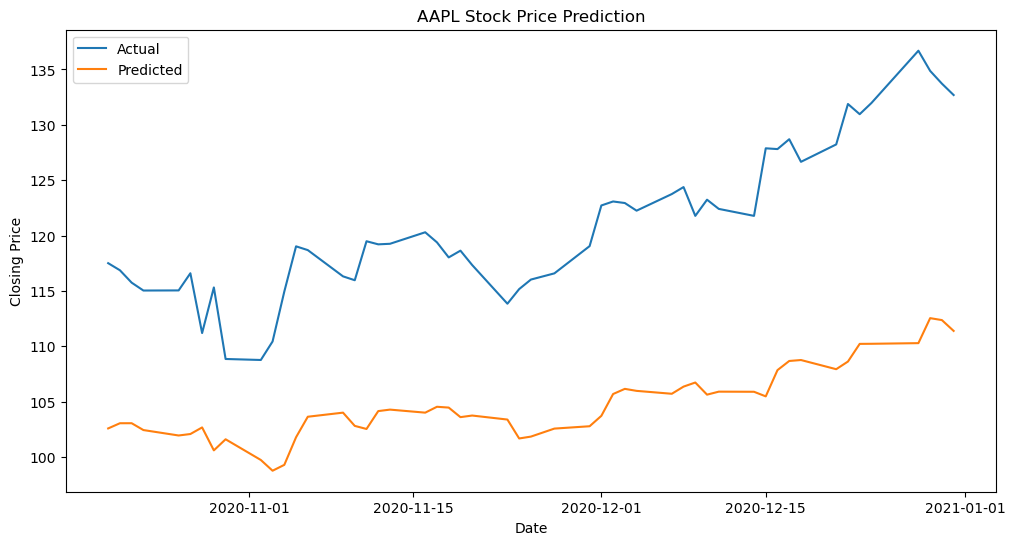

In [38]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Function to retrieve data from Yahoo Finance
def get_yahoo_finance_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Function to preprocess data
def preprocess_data(data):
    # Drop any missing values
    data.dropna(inplace=True)
    # Select only the 'Close' column
    data = data[['Close']]
    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Function to split data into train and test sets
def train_test_split(data, train_size):
    train = data[:train_size]
    test = data[train_size:]
    return train, test

# Function to train ARIMA model
def train_arima_model(train, test):
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    return predictions

# Function to create and train ANN model
def create_ann_model(train, test):
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test = test[:, :-1], test[:, -1]

    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

    predictions = model.predict(X_test)

    return predictions

# Function to combine ARIMA and ANN predictions
def hybrid_model(train, test):
    arima_predictions = np.array(train_arima_model(train, test))
    ann_predictions = create_ann_model(train, test)

    combined_predictions = (arima_predictions + ann_predictions.flatten()) / 2

    return combined_predictions

# Main function
def main():
    # Get data from Yahoo Finance
    ticker = 'AAPL'  # Example: Apple Inc.
    start_date = '2020-01-01'
    end_date = '2021-01-01'
    data = get_yahoo_finance_data(ticker, start_date, end_date)

    # Preprocess data
    scaled_data, scaler = preprocess_data(data)

    # Split data into train and test sets
    train_size = int(len(scaled_data) * 0.8)
    train_data, test_data = train_test_split(scaled_data, train_size)

    # Make predictions using ARIMA-ANN hybrid model
    predictions = hybrid_model(train_data, test_data)

    # Invert predictions
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    # Evaluate the model
    test_actual = scaler.inverse_transform(test_data[:, -1].reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(test_actual, predictions))
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Plotting the predictions
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[train_size:], test_actual, label='Actual')
    plt.plot(data.index[train_size:], predictions, label='Predicted')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
